In [1]:
from tsnecuda import TSNE
import numpy as np
import os
import PIL.ImageOps
from tqdm import tqdm
import matplotlib.pyplot as plt
import cv2

In [2]:
# spg_features, QuickDraw_features, 
feature_folder = "/raid/xiaoyuz1/sketch_datasets/spg_features/clip/face"
flip = False
# feature_folder = "/raid/xiaoyuz1/sketch_datasets/QuickDraw_features/clip/dragon"
# flip = True

# feature_folder = "/raid/xiaoyuz1/sketch_datasets/spg_body/angel_feature"
# flip = False

feature_folder = "/raid/xiaoyuz1/sketch_datasets/face_features/clip/0"
flip = False

In [3]:
feature_folder_template = "/raid/xiaoyuz1/sketch_datasets/face_features/clip/{}"
flip = False

data_dict = {
    0: (256, 15),
    1: (256, 15),
    2: (256, 15),
    4: (100, 10),
    6: (256, 7),
}
part_idx = 6
feature_folder = feature_folder_template.format(str(part_idx))
pca_dim, num_clusters = data_dict[part_idx]

In [4]:
# L = []
# folder = '/raid/xiaoyuz1/sketch_datasets/angel'
# for file in os.listdir(folder):
#     if not file.endswith("png"):
#         continue
    
#     L.append(file)
# print(len(L))

In [5]:
all_features = []
all_images = []

for file in os.listdir(feature_folder):
    #print(file)
    if not file.endswith(".npy"):
        continue
        
    img_path = "{}.txt".format(file.split(".n")[0])
    feat = np.load(os.path.join(feature_folder, file))
    #print(feat.shape)
    # all_features.append(feat)
    image_paths = None
    with open(os.path.join(feature_folder, img_path), 'r') as f:
        lines = f.readlines()
        image_paths = [line.strip() for line in lines]
        #all_images += image_paths
    #print(len(image_paths))
        
    for feati,pathi in zip(feat,image_paths):
        #if pathi.split("/")[-1] in L:
        all_features += [feati]
        all_images += [pathi]

In [6]:
features = np.vstack(all_features)
print(features.shape)

(572, 512)


In [7]:
tsne = TSNE(n_iter=5000, verbose=1, perplexity=1000, num_neighbors=128)
tsne_results = tsne.fit_transform(features)

In [8]:
def scale_to_01_range(x):
    value_range = (np.max(x) - np.min(x))
    starts_from_zero = x - np.min(x)
    return starts_from_zero / value_range

tx = scale_to_01_range(tsne_results[:,0])
ty = scale_to_01_range(tsne_results[:,1])

In [9]:
def scale_image(image, max_image_size):
    image_height, image_width, _ = image.shape

    scale = max(1, image_width / max_image_size, image_height / max_image_size)
    image_width = int(image_width / scale)
    image_height = int(image_height / scale)

    image = cv2.resize(image, (image_width, image_height))
    return image

def compute_plot_coordinates(image, x, y, image_centers_area_size, offset):
    image_height, image_width, _ = image.shape
    center_x = int(image_centers_area_size * x) + offset
    center_y = int(image_centers_area_size * (1 - y)) + offset

    # knowing the image center, compute the coordinates of the top left and bottom right corner
    tl_x = center_x - int(image_width / 2)
    tl_y = center_y - int(image_height / 2)
    br_x = tl_x + image_width
    br_y = tl_y + image_height

    return tl_x, tl_y, br_x, br_y


def visualize_tsne_images(tx, ty, images, labels = None, plot_size=10000, max_image_size=200, flip=False):
    # we'll put the image centers in the central area of the plot
    # and use offsets to make sure the images fit the plot
    offset = max_image_size // 2
    image_centers_area_size = plot_size - 2 * offset

    tsne_plot = 255 * np.ones((plot_size, plot_size, 3), np.uint8)
    
    plt.figure(figsize=(30,30))

    # now we'll put a small copy of every image to its corresponding T-SNE coordinate
    for image_path, x, y in tqdm(
        zip(images, tx, ty),
        desc='Building the T-SNE plot',
        total=len(images)
    ):
        image = cv2.imread(image_path)
        if flip:
            image = cv2.bitwise_not(image)

        image = scale_image(image, max_image_size)
        tl_x, tl_y, br_x, br_y = compute_plot_coordinates(image, x, y, image_centers_area_size, offset)
        tsne_plot[tl_y:br_y, tl_x:br_x, :] = image

    plt.imshow(tsne_plot[:, :, ::-1])
    plt.show()

In [12]:
len(tx),len(all_images)

(572, 572)

Building the T-SNE plot: 100%|██████████| 572/572 [00:00<00:00, 1048.75it/s]


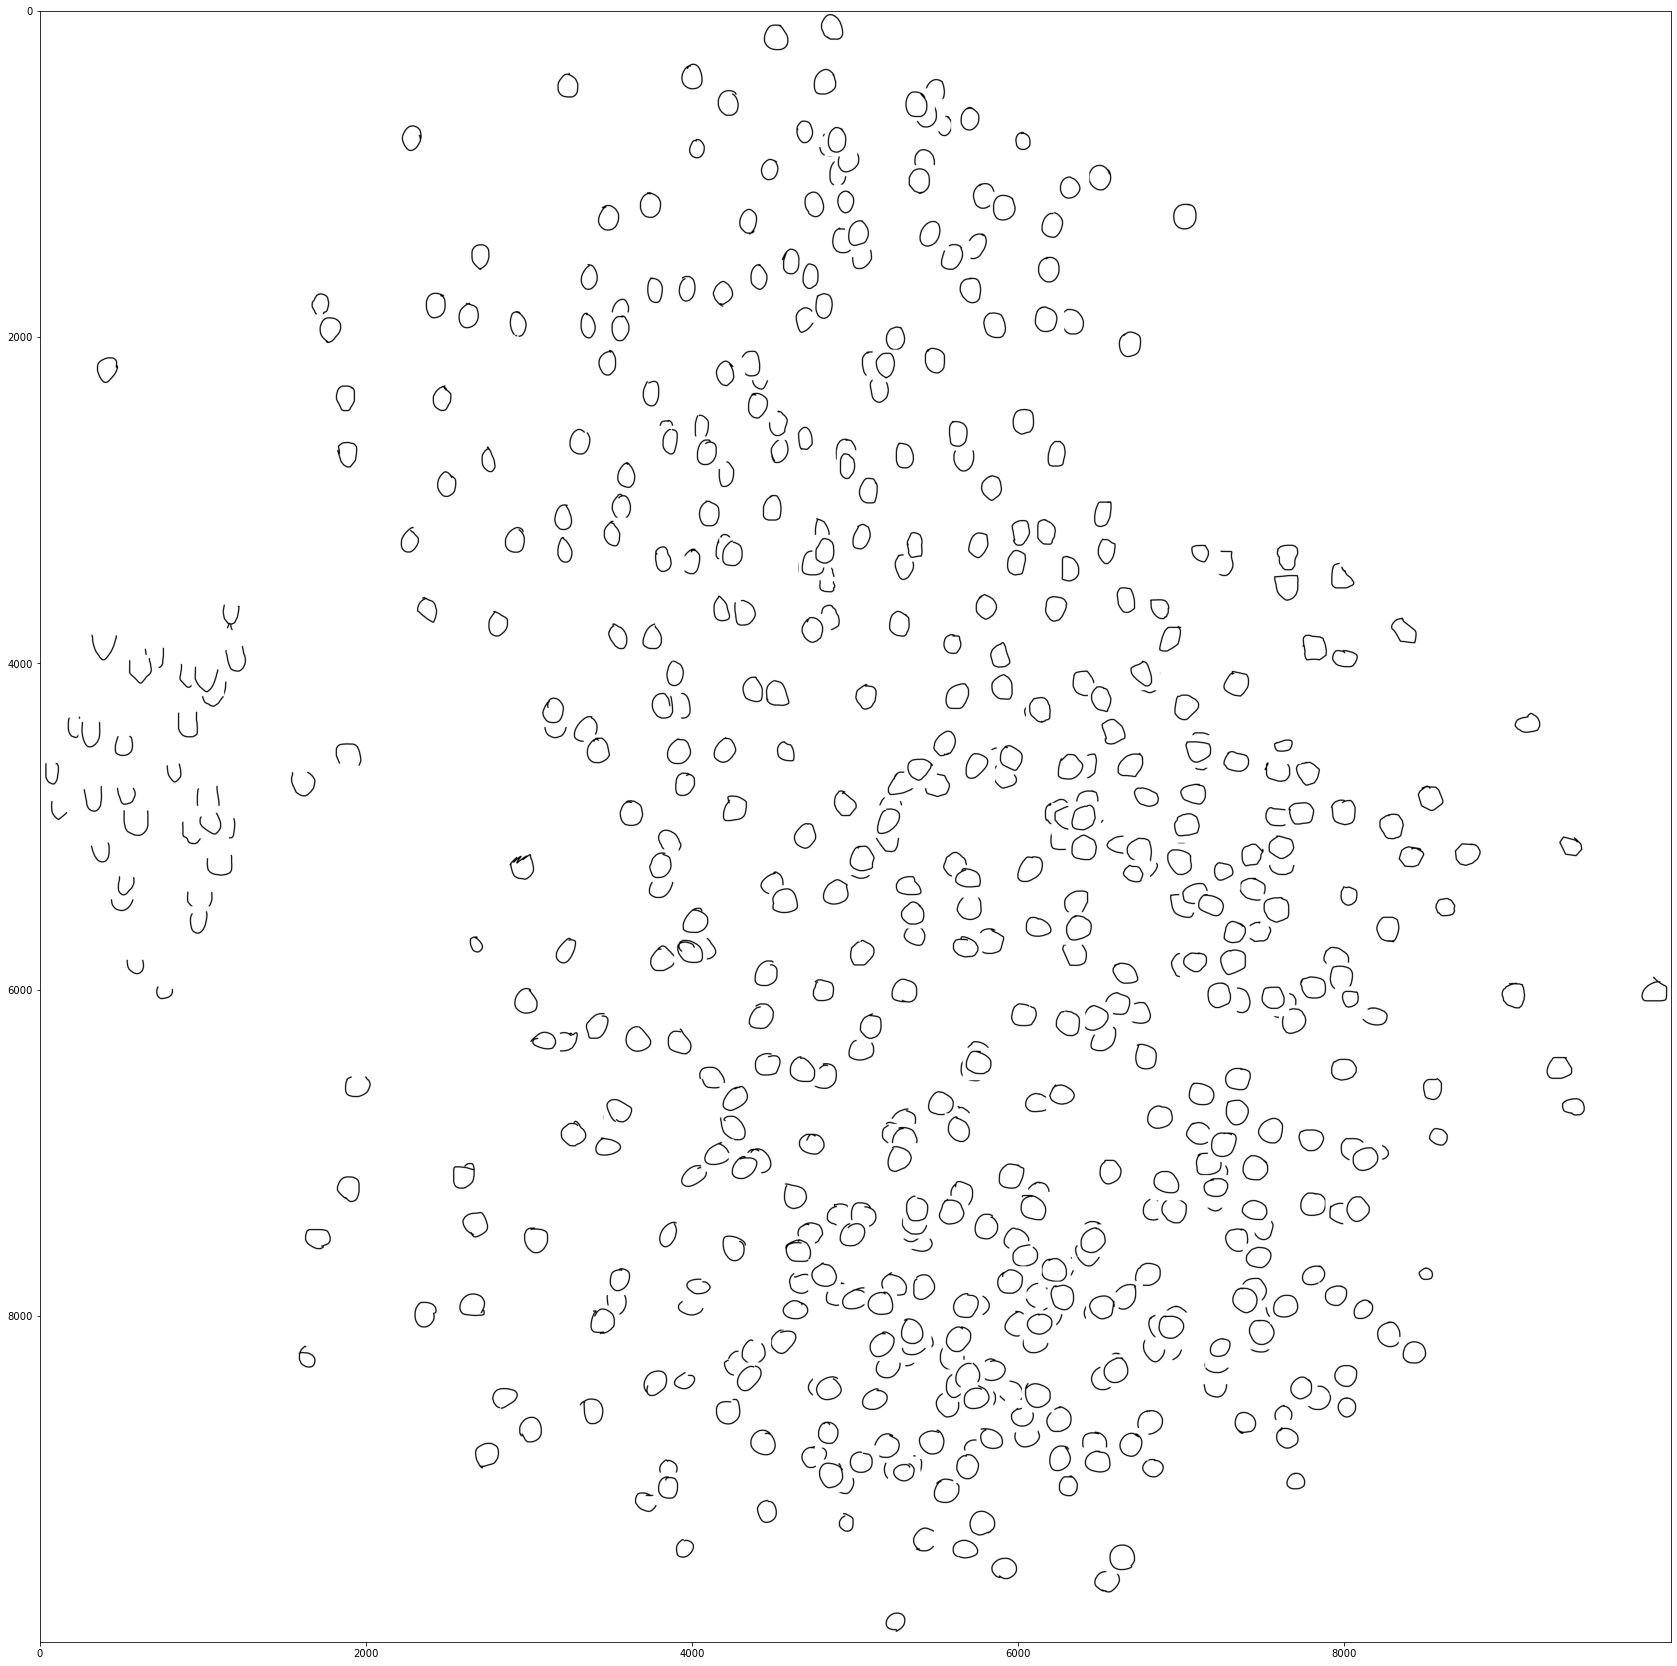

In [10]:
visualize_tsne_images(tx, ty, all_images, plot_size=10000, max_image_size=200, flip=flip)

In [24]:
all_image_indices = [int(x.split("/")[-1].split(".")[0]) for x in all_images]

In [32]:
import pandas as pd
dfn = pd.read_csv('/raid/xiaoyuz1/amazon_turk/2022_03_23_release_2/df_all.csv')

def compute_text_coordinates(x, y, image_centers_area_size, offset):
    center_x = int(image_centers_area_size * x) + offset
    center_y = int(image_centers_area_size * (1 - y)) + offset
    return center_x, center_y

def visualize_tsne_texts(tx, ty, images, plot_size=10000, max_image_size=200):
    offset = max_image_size // 2
    image_centers_area_size = plot_size - 2 * offset

    tsne_plot = 255 * np.ones((plot_size, plot_size, 3), np.uint8)
    
    plt.figure(figsize=(30,30))

    # now we'll put a small copy of every image to its corresponding T-SNE coordinate
    for img_idx, x, y in tqdm(zip(images, tx, ty),desc='Building the T-SNE plot',total=len(images)):
        
        texts = dfn[(dfn['image'] == img_idx) & (dfn['part'] == part_idx)]['no_punc_str']
        cx,cy = compute_text_coordinates(x, y, image_centers_area_size, offset)
        for t in texts:
            plt.scatter(cx,cy,alpha=0.4/len(texts))
            plt.annotate(t,
                     xy=(cx, cy),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom',
                     fontsize=9,
                    )
        
    plt.show()

Building the T-SNE plot: 100%|██████████| 572/572 [00:03<00:00, 149.04it/s]


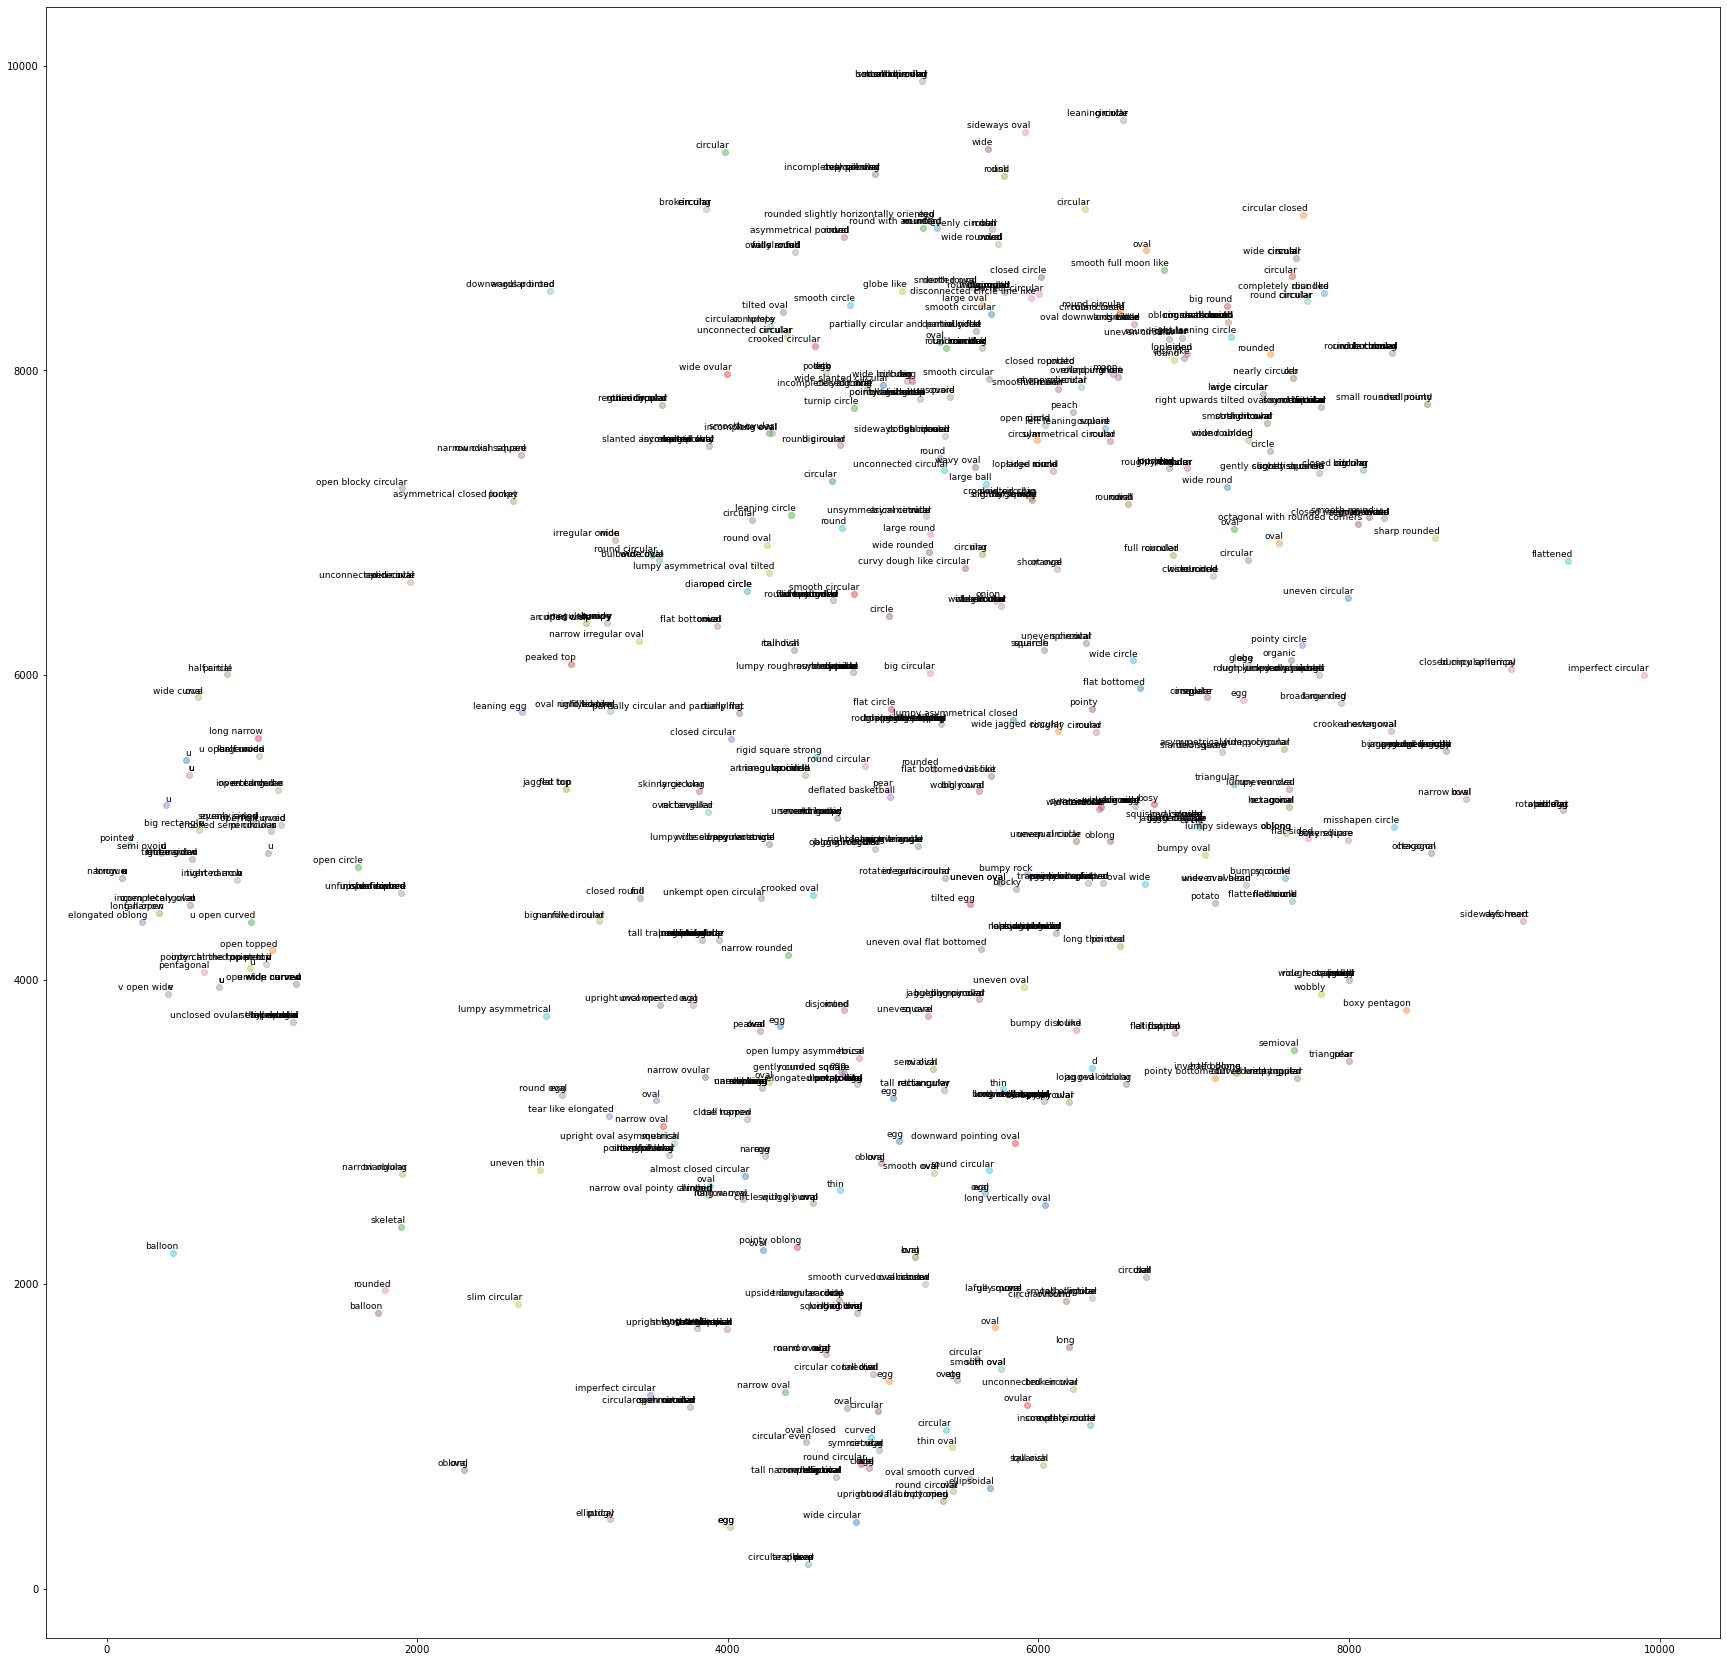

In [34]:
visualize_tsne_texts(tx,ty,all_image_indices)

In [19]:
tsne_fdr = os.path.join(feature_folder, 'tsne_results')
print("Write TSNE information to: ", tsne_fdr)
if not os.path.exists(tsne_fdr):
    os.mkdir(tsne_fdr)

with open(os.path.join(tsne_fdr, 'tsne.npy'), 'wb') as f:
    np.save(f, np.hstack([tx.reshape(-1,1),ty.reshape(-1,1)]))
# with open(os.path.join(tsne_fdr, 'tsne_y.npy'), 'wb') as f:
#     np.save(f, ty)  

with open(os.path.join(tsne_fdr, 'image.txt'), "w+") as f:
    f.write("\n".join(all_images))

Write TSNE information to:  /raid/xiaoyuz1/sketch_datasets/face_features/clip/6/tsne_results


In [33]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [68]:
from sklearn.metrics import silhouette_score

sil = []
kmax = 30

pca = PCA(n_components=pca_dim, random_state=22)
pca.fit(features)
x = pca.transform(features)

# dissimilarity would not be defined for a single cluster, thus, minimum number of clusters should be 2
for k in range(5, kmax+1):
    kmeans = KMeans(n_clusters = k).fit(x)
    labels = kmeans.labels_
    sil.append(silhouette_score(x, labels, metric = 'euclidean'))

In [52]:
for k in range(31,50):
    kmeans = KMeans(n_clusters = k).fit(x)
    labels = kmeans.labels_
    sil.append(silhouette_score(x, labels, metric = 'euclidean'))

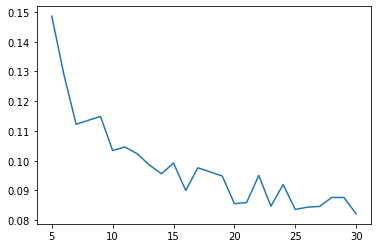

In [69]:
plt.plot(range(5, 31), sil)
plt.show()

In [34]:
pca = PCA(n_components=pca_dim, random_state=22)
pca.fit(features)
x = pca.transform(features)

In [35]:

kmeans = KMeans(n_clusters=num_clusters, random_state=22)
kmeans.fit(x)

KMeans(n_clusters=7, random_state=22)

In [42]:
np.unique(kmeans.labels_)

array([0, 1, 2, 3, 4, 5, 6], dtype=int32)

In [37]:
groups = {}
for file, cluster in zip(all_images, kmeans.labels_):
    if cluster not in groups.keys():
        groups[cluster] = []
        groups[cluster].append(file)
    else:
        groups[cluster].append(file)

In [38]:
import PIL
def view_cluster(cluster, save_path=None):
    fig = plt.figure(figsize = (25,25))
    fig.patch.set_alpha(1)  # solution
    # gets the list of filenames for a cluster
    files = groups[cluster]
    # only allow up to 30 images to be shown at a time
#     if len(files) > 30:
#         print(f"Clipping cluster size from {len(files)} to 30")
#         files = files[:29]
    # plot each image in the cluster
    for index, file in enumerate(files):
        plt.subplot(20,20,index+1);
        img = PIL.Image.open(file)
        img = img.convert(mode='RGB')
        
        if flip:
            img = PIL.ImageOps.invert(img)

        img = np.array(img)
        plt.imshow(img)
        plt.title(file.split("/")[-1])
        plt.axis('off')
    
    if save_path is not None:
        plt.savefig(save_path)
    plt.show()
    plt.close()

2


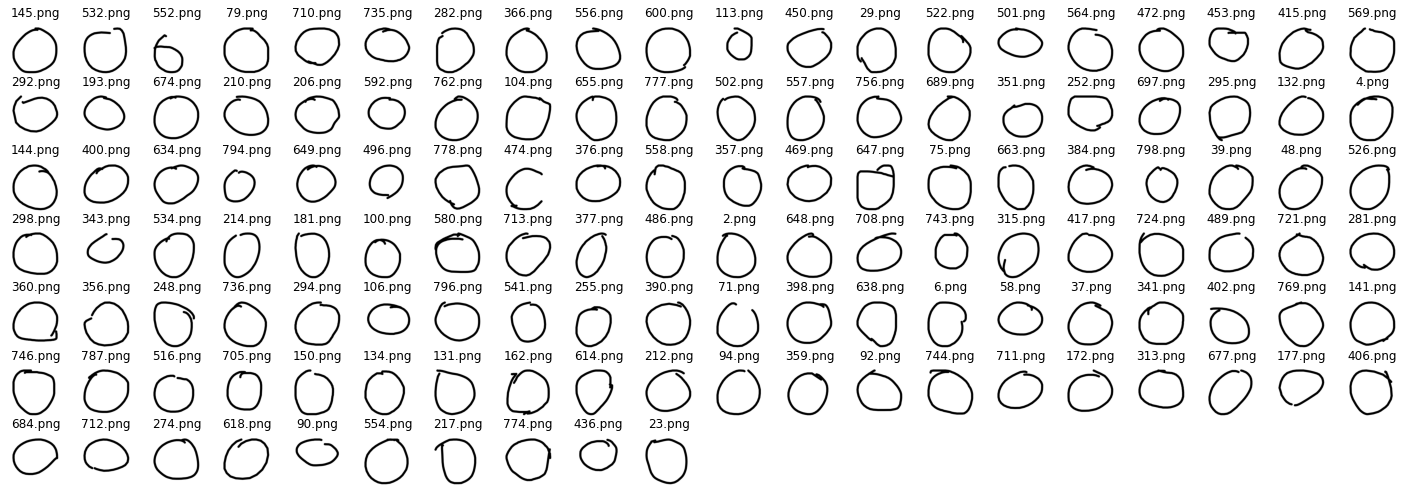

1


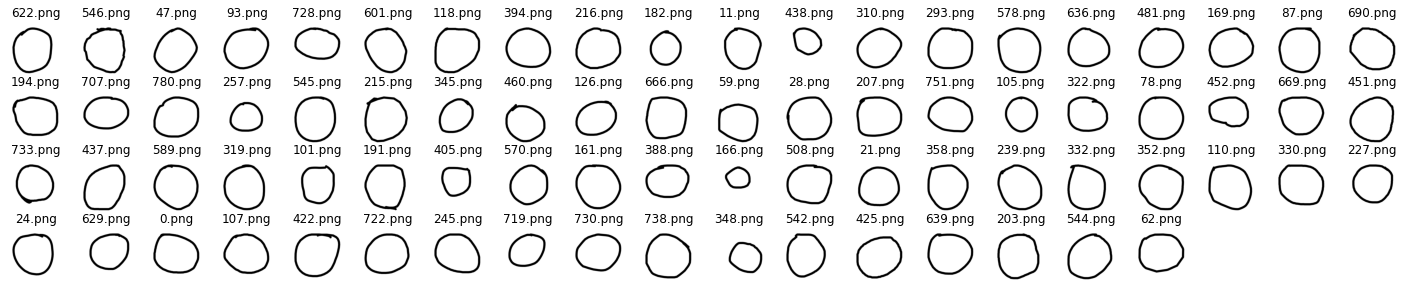

6


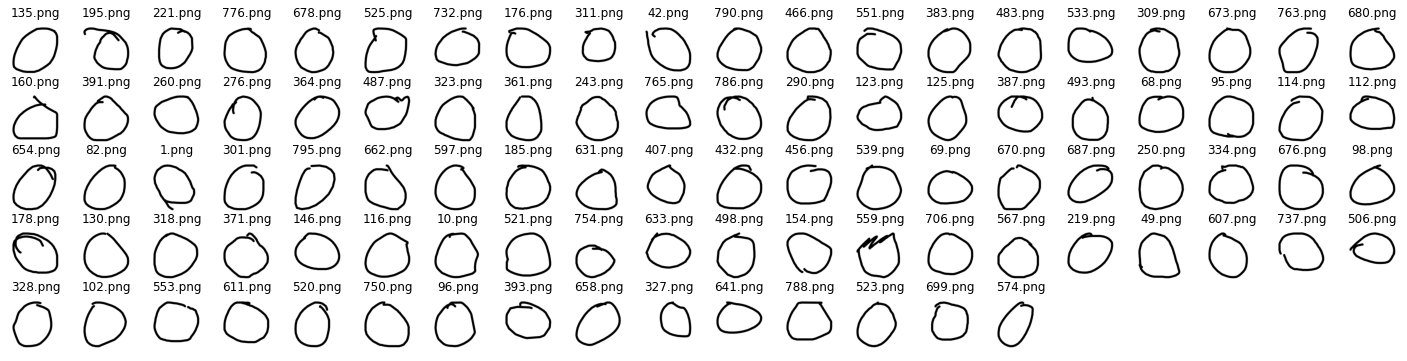

4


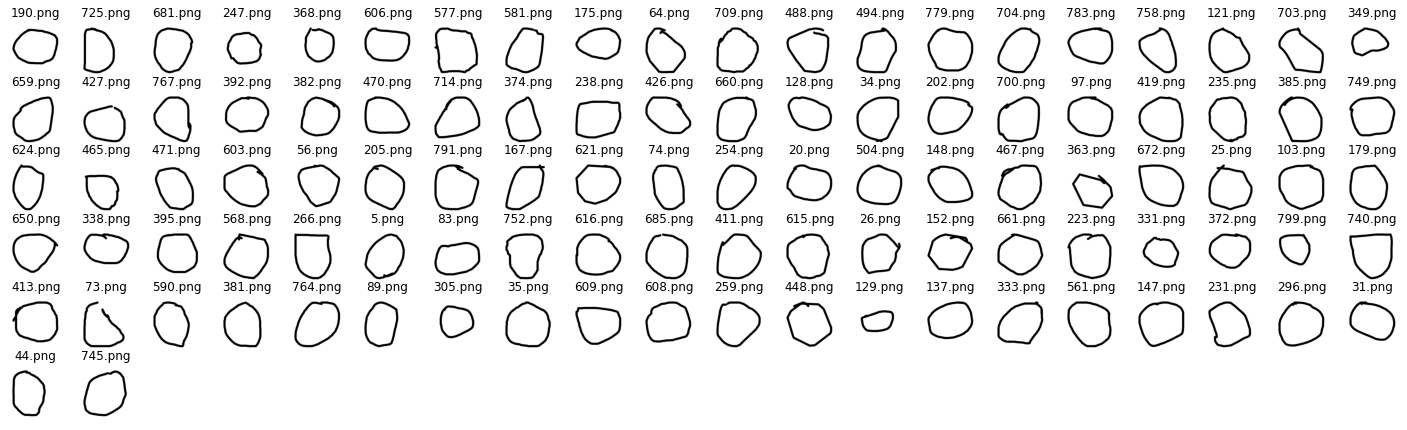

5


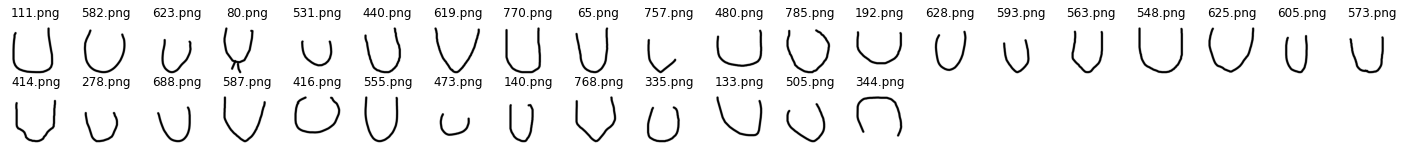

0


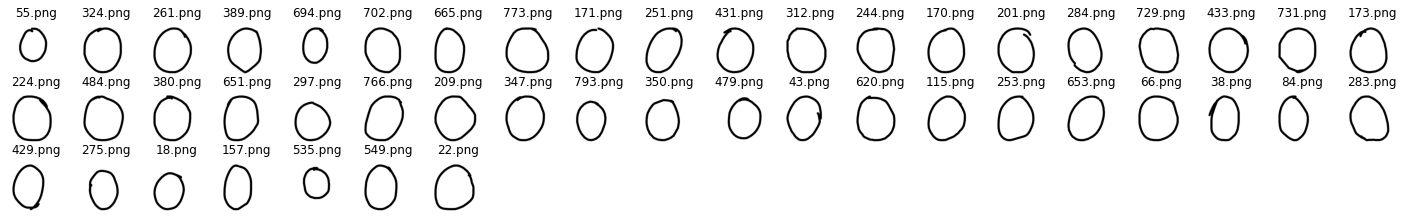

3


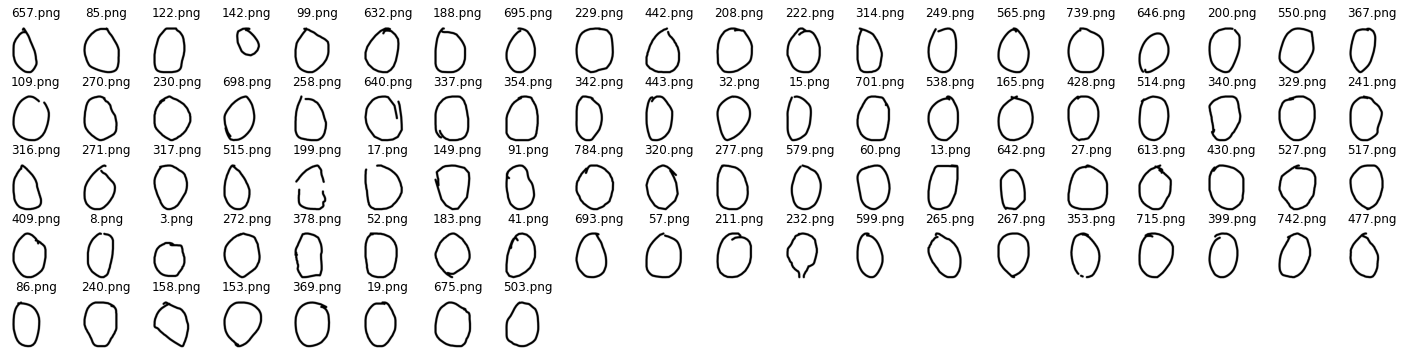

In [39]:
# cluster_fdr = os.path.join(feature_folder, 'type1_clustering_result')
# if not os.path.exists(cluster_fdr):
#     os.mkdir(cluster_fdr)
    
for k in groups:
    print(k)
    #save_path = os.path.join(cluster_fdr, 'cluster_{}.png'.format(k))
    #print(k, len(groups[k]))
    view_cluster(k)

In [43]:
import collections
groups_idx = collections.defaultdict(list)
for file, cluster in zip(all_images, kmeans.labels_):
    idx = int(file.split("/")[-1].split(".")[0]) 
    groups_idx[cluster].append(idx)

In [44]:
image_indices = [int(file.split("/")[-1].split(".")[0]) for file in all_images]
idx_to_i = dict(zip(image_indices, range(len(all_images))))
i_to_idx = dict(zip(range(len(all_images)), image_indices))
face_indices = []
png_to_group = {}
for c,L in groups_idx.items():
    face_indices += L
    png_to_group.update(dict(zip(L, [c]*len(L))))

In [45]:
# from scipy.spatial import distance


# cosine_distances = np.zeros((len(all_images), len(all_images)))
# for i,idx in enumerate(image_indices):
#     for j,idx2 in enumerate(image_indices):
#         cosine_distances[i][j] = distance.cosine(features[i], features[j])

In [46]:
# order = collections.defaultdict(lambda : np.zeros((len(all_images), 2)).astype(int))
# for i,idx in enumerate(image_indices):
#     j_order = np.argsort(cosine_distances[i])[::-1]
#     for order_i,j in enumerate(j_order):
#         order[idx][order_i][0] = png_to_group[i_to_idx[j]]
#         order[idx][order_i][1] = i_to_idx[j]

In [47]:
num_cluster_random = 1
if part_idx == 6:
    selection_pair = []
    for c,L in groups_idx.items():
        
        if c != 5:
            L = np.random.choice(L, len(L)//2)
            L = list(L)
        
        other_groups = list(range(num_clusters))
        print(other_groups, c)
        other_groups.remove(c)
        
        pair_choices = np.random.choice(other_groups, (len(L), num_cluster_random))
        for idx1,indices in zip(L, pair_choices):
            for og in indices:
                #print(og, len(groups_idx[og]))
                for idx2 in np.random.choice(groups_idx[og], 1):
                    selection_pair.append([idx1, idx2])
else:
    selection_pair = []
    for c,L in groups_idx.items():
        other_groups = list(range(num_clusters))
        other_groups.remove(c)
        pair_choices = np.random.choice(other_groups, (len(L), num_cluster_random))
        for idx1,indices in zip(L, pair_choices):
            for og in indices:

                for idx2 in np.random.choice(groups_idx[og], 1):
                    selection_pair.append([idx1, idx2])
selection_pair = np.asarray(selection_pair)

[0, 1, 2, 3, 4, 5, 6] 2
[0, 1, 2, 3, 4, 5, 6] 1
[0, 1, 2, 3, 4, 5, 6] 6
[0, 1, 2, 3, 4, 5, 6] 4
[0, 1, 2, 3, 4, 5, 6] 5
[0, 1, 2, 3, 4, 5, 6] 0
[0, 1, 2, 3, 4, 5, 6] 3


In [48]:
idx2, count = np.unique(selection_pair, return_counts=True)
group_count = collections.defaultdict(list)
for idx,c in zip(idx2,count):
    group_count[png_to_group[idx]].append(c)
for g,counts in group_count.items():
    print(g, np.sum(counts)/len(groups_idx[g]))

6 0.9368421052631579
3 0.9545454545454546
4 0.8823529411764706
1 1.025974025974026
0 1.553191489361702
2 0.8384615384615385
5 2.3636363636363638


In [49]:
tsne_fdr = os.path.join(feature_folder, 'group')
if not os.path.exists(tsne_fdr):
    os.mkdir(tsne_fdr)
with open(os.path.join(feature_folder, 'group', 'group.npy'), 'wb') as f:
    np.save(f, selection_pair)

import pickle
with open(os.path.join(feature_folder, 'group', 'cluster_group.pickle'), 'wb+') as f:
    pickle.dump(groups_idx, f)

In [17]:
# import shutil
# cluster_img_fdr = os.path.join(feature_folder, 'clustered_img')
# if not os.path.exists(cluster_img_fdr):
#     os.mkdir(cluster_img_fdr)
# for k in range(100):
#     group_img_fdr = os.path.join(cluster_img_fdr, str(k))
#     if not os.path.exists(group_img_fdr):
#         os.mkdir(group_img_fdr)
#     for file in groups[k]:
#         shutil.copy(file, os.path.join(group_img_fdr, file.split("/")[-1]))

In [16]:
# # this is just incase you want to see which value for k might be the best 
# sse = []
# list_k = list(range(3, 50))

# for k in list_k:
#     km = KMeans(n_clusters=k, random_state=22)
#     km.fit(x)
    
#     sse.append(km.inertia_)

# # Plot sse against k
# plt.figure(figsize=(6, 6))
# plt.plot(list_k, sse)
# plt.xlabel(r'Number of clusters *k*')
# plt.ylabel('Sum of squared distance')